#Drive Bağlantısını Kurma


Not :çalışma zamanı : çalışma zamanının türünü değiştir - GPU seçmeliyiz. Sağ üst kısımda yer alan ram kısmından baplantıyı aktif hale getirmeliyiz.

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Kaggle Veri Setini Otomatik Olarak Klasöre İndirme 

Eğer veriyi 1 kere indirdiyseniz burada hata alırsınız, bir daha indirmenize gerek yok.








Kaggle'a girip,  my account a geliyoruz.  API - expire api token , sonra create new api token diyoruz. sonra çalıştırıyoruz.  kaggle. json dosyasi iniyor.  my drive'da Kaggle dosya oluşturuyoruz. my drive altina açtığımız Kaggle isimli dosyanin içine kaggle.json isimli dosyayi eklyioruz ve calıştırıyoruz. Data indikten sonra unzip kodunuda çalıştırınca images adlı klosörün adını data olarak değiştirelim. Kaggle klasörünün adını da VisionX olarak değiştirelim ve diğer kod satırlarını çalıştıralım.


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!pip install kaggle

In [ ]:
!kaggle --version

Kaggle API 1.5.4


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.8:
  Successfully uninstalled kaggle-1.5.8
     |████████████████████████████████| 1.5MB 10.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=1d546e0d0e486225bc17509d850cd81898f36fb404d2f0407e34616a2b8e5dac
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 99% 774M/779M [00:08<00:00, 81.9MB/s]
100% 779M/779M [00:08<00:00, 99.6MB/s]


In [ ]:
!ls

images	     plant-pathology-2020-fgvc7.zip  test.csv
kaggle.json  sample_submission.csv	     train.csv


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

#Kütüphaneleri Kurma

In [ ]:
import torch
import torch.nn
from torchvision.transforms import ToTensor, ToPILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/VisionX/")
!pwd

/content/gdrive/My Drive/VisionX


In [ ]:
!ls "/content/gdrive/My Drive/VisionX/"

'AugmentedMultipleDisease.ipynb adlı not defterinin kopyası'
 data
 gercek.csv
 output.csv
 PlantPathology.ipynb
 sample_submission.csv
 shuffled_train.csv
 test.csv
 train.csv


In [ ]:
PATH = Path("/content/gdrive/My Drive/VisionX/data/images/")

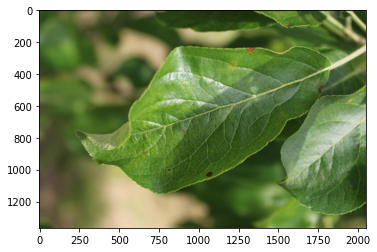

In [ ]:
img = Image.open(PATH/"Train_1815.jpg")
plt.imshow(img);

In [ ]:
train_df_names = pd.read_csv("sample_submission.csv")["image_id"].values
test_df_names = pd.read_csv("test.csv")["image_id"].values
len(train_df_names), len(test_df_names)

(1821, 1821)

In [ ]:
train_df_names

array(['Test_0', 'Test_1', 'Test_2', ..., 'Test_1818', 'Test_1819',
       'Test_1820'], dtype=object)

In [ ]:
train_imgs = [np.array(Image.open(PATH/(i+".jpg"))) for i in train_df_names[:1]]
len(train_imgs) ,train_imgs[0].shape

(1, (1365, 2048, 3))

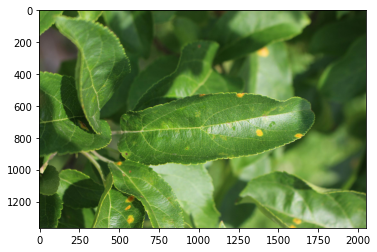

In [ ]:
plt.imshow(train_imgs[0]);

In [ ]:
def convert_to_label(data):
    data = torch.argmax(data).item()
    labels = { 3: "scab",
               1: "multiple_diseases",
               0: "healthy",
               2: "rust",
             }
    return labels[data]

In [ ]:
"""def transform_image(pth):
    img = Image.open(pth)
    return torch.tensor(np.array(img.resize((256,256))), dtype=torch.float32)"""

'def transform_image(pth):\n    img = Image.open(pth)\n    return torch.tensor(np.array(img.resize((256,256))), dtype=torch.float32)'

In [ ]:
def transform_image(pth): #Hocanın yazdığı
    img = Image.open(pth)
    return ((ToTensor()(img.resize((256,256)))).type(torch.float32))

In [ ]:
class Dataset:
    def __init__(self, df, path):
        self.df = df
        self.path = path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idxs):
        if isinstance(idxs, int):
            imgs = transform_image(self.path/(self.df["image_id"][idxs]+".jpg"))
            labels = torch.tensor(self.df.iloc[:,1:].iloc[idxs].values, dtype=torch.float32)
            
            return imgs.cuda(), labels.cuda()
        else:
            sub_df = self.df.iloc[idxs]
            imgs = []
            labels = []
            for i in range(len(idxs)):
                img = transform_image(self.path/(sub_df["image_id"].iloc[i]+".jpg"))
                imgs.append(img)
                label = torch.tensor(sub_df.iloc[:,1:].iloc[i].values, dtype=torch.float32)
                labels.append(label)
                
            return torch.stack(imgs,dim=0).cuda(), torch.stack(labels,dim=0).cuda()

In [ ]:
class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [ ]:
df = pd.read_csv("sample_submission.csv")
# train_df = df.iloc[]
validation_size = 360
train_df = df.iloc[:1400,:]
valid_df = df.sample(n=360)
train_df.shape, valid_df.shape

((1400, 5), (360, 5))

In [ ]:
valid_df.to_csv("gercek.csv")

In [ ]:
train_ds = Dataset(train_df, PATH)
train_dl = DataLoader(train_ds, 128)

valid_ds = Dataset(valid_df, PATH)
valid_dl = DataLoader(valid_ds, 128)

In [ ]:
x1,y1 = next(iter(valid_dl))
x1.shape, y1.shape

In [23]:
x,y = train_ds[0]
x.shape

torch.Size([3, 256, 256])

In [24]:
def validation_acc(model):
    return torch.stack([accuracy_multi(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [25]:
x,y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([128, 3, 256, 256]), torch.Size([128, 4]))

In [ ]:
'''def accuracy(predictions, target):
    preds = [torch.argmax(i).item() for i in predictions]
    targs = [torch.argmax(i).item() for i in target]
    return np.mean([preds[i]==targs[i] for i in range(len(preds))])

In [27]:
def accuracy(predictions, target):
    predictions = predictions.view(-1,4)
    target = target.view(-1,4)
    preds = [torch.argmax(i).item() for i in predictions]
    targs = [torch.argmax(i).item() for i in target]
    return np.mean([preds[i]==targs[i] for i in range(len(preds))])

In [28]:
def validation_acc(model, valid_dl):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [29]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

In [30]:
preds = torch.tensor([0.3,0.2,0.4,0.1]).view(1,4)
preds.shape
log_softmax(preds)

tensor([[-1.3425, -1.4425, -1.2425, -1.5425]])

In [31]:
def binary_cross_entropy_logits(preds, targets):
    preds = log_softmax(preds)
    return torch.where(targets==1, 1-preds, preds).log().mean()

In [32]:
preds = torch.tensor([0,0.8,-5,0.4],dtype=torch.float32).view(1,4)
log_softmax(preds)
target = torch.tensor([0,1,0,0],dtype=torch.float32).view(1,4)
binary_cross_entropy_logits(preds, target).item()

nan

In [33]:
torch.where(target==1, 1-preds, preds).log().mean()

tensor(nan)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
model = nn.Sequential(
        nn.Conv2d(3,8,5,padding=2,stride=2),nn.ReLU(), nn.BatchNorm2d(8), nn.Dropout2d(0.05),
        nn.Conv2d(8,16,5,padding=1,stride=2), nn.ReLU(), nn.BatchNorm2d(16), nn.Dropout2d(0.1),
        nn.Conv2d(16,32,5,padding=1,stride=2), nn.ReLU(), nn.BatchNorm2d(32), nn.Dropout2d(0.2),
        nn.Flatten(),
        nn.Linear(32*31*31,64), nn.ReLU(), nn.Dropout(0.4),
        nn.Linear(64,4)
).cuda()

In [36]:
optim = torch.optim.Adam(model.parameters(), lr=0.002)

In [37]:
criterion = nn.BCEWithLogitsLoss() # Ne işe yarıyor?

In [38]:
def train_model(model, loss_criterion, optimizer, data_loader, epochs, valid_epoch):
    #model = model.train()
    for epoch in range(1,epochs+1):
        model = model.train()
        general_loss = 0
        for xb, yb in data_loader: #xb image, yb label döndürüyor. İkisi de tensor
            optimizer.zero_grad()
            
            predictions = model(xb)
            y= predictions.detach().cpu().numpy()
            np.savetxt("output.csv",y)
            loss = loss_criterion(predictions, yb)
            loss.backward()
            
            optimizer.step()
            
            general_loss += loss.item()
            
        if epoch % valid_epoch == 0:
          model = model.eval()
          with torch.no_grad():
            print("Epoch: [%d] | Loss: %.3f | Accuracy:%.2f"  % (epoch, general_loss,accuracy(predictions,yb))) # accuracy fonksiyonu yaz.

In [39]:
train_model(model, criterion, optim, valid_dl, 20, 1)

Epoch: [1] | Loss: 2.408 | Accuracy:0.24
Epoch: [2] | Loss: 2.283 | Accuracy:0.32
Epoch: [3] | Loss: 2.022 | Accuracy:0.25
Epoch: [4] | Loss: 1.962 | Accuracy:0.41
Epoch: [5] | Loss: 1.908 | Accuracy:0.21
Epoch: [6] | Loss: 1.879 | Accuracy:0.17
Epoch: [7] | Loss: 1.870 | Accuracy:0.27
Epoch: [8] | Loss: 1.843 | Accuracy:0.20
Epoch: [9] | Loss: 1.819 | Accuracy:0.27
Epoch: [10] | Loss: 1.811 | Accuracy:0.28
Epoch: [11] | Loss: 1.805 | Accuracy:0.30
Epoch: [12] | Loss: 1.803 | Accuracy:0.61
Epoch: [13] | Loss: 1.804 | Accuracy:0.68
Epoch: [14] | Loss: 1.789 | Accuracy:0.42
Epoch: [15] | Loss: 1.792 | Accuracy:0.13
Epoch: [16] | Loss: 1.775 | Accuracy:0.15
Epoch: [17] | Loss: 1.773 | Accuracy:0.07
Epoch: [18] | Loss: 1.767 | Accuracy:0.14
Epoch: [19] | Loss: 1.772 | Accuracy:0.18
Epoch: [20] | Loss: 1.765 | Accuracy:0.29
